In [1]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import os

rnd = 384
np.random.seed(rnd)
torch.manual_seed(rnd)

In [2]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/adult_clear.csv')
df = df[df["workclass"] != "?"]
df = df[df["occupation"] != "?"]
df = df[df["native-country"] != "?"]
df.replace(['Divorced', 'Married-AF-spouse',
            'Married-civ-spouse', 'Married-spouse-absent',
            'Never-married', 'Separated', 'Widowed'],
           ['notmarried', 'married', 'married', 'married',
            'notmarried', 'notmarried', 'notmarried'], inplace=True)
df['education'].replace(['Preschool', '10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th'], 'dropout',
                        inplace=True)
df['education'].replace(['HS-Grad', 'HS-grad'], 'HighGrad', inplace=True)
df['education'].replace(['Some-college', 'Assoc-acdm', 'Assoc-voc'], 'CommunityCollege', inplace=True)
df = df[df.race == 'White']
# excludes 10 observations
df = df[df['workclass'] != 'Never-worked']
# excludes 14 observations
df = df[df['occupation'] != 'Armed-Forces']
# excludes 21 observations
df = df[df['workclass'] != 'Without-pay']
df.drop(['fnlwgt', 'educational-num', 'relationship', 'race', 'capital-gain', 'capital-loss'],
            axis=1, inplace=True)
df['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Gov', inplace=True)
df['workclass'].replace(['Private', 'Self-emp-not-inc', 'Self-emp-inc'], 'Private', inplace=True)
df['occupation'].replace(
    ['Craft-repair', 'Machine-op-inspct', 'Handlers-cleaners', 'Transport-moving', 'Adm-clerical',
     'Farming-fishing'], 'BlueCollar', inplace=True)
df['occupation'].replace(['Other-service', 'Protective-serv', 'Tech-support', 'Priv-house-serv'], 'Services',
                         inplace=True)
df['occupation'].replace(['Exec-managerial'], 'ExecManagerial', inplace=True)
df['occupation'].replace(['Prof-specialty'], 'ProfSpecialty', inplace=True)
df['education'].replace(['Prof-school'], 'ProfSchool', inplace=True)
df['native-country'].replace(['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', \
                              'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',\
                              'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland',\
                              'Italy', 'Jamaica', 'Japan', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)',\
                              'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South',\
                              'Taiwan','Thailand', 'Trinadad&Tobago', 'Vietnam','Yugoslavia'], 'Non_US', inplace=True)
df.rename(columns={'hours-per-week': 'hoursPerWeek'}, inplace=True)
df.rename(columns={'marital-status': 'marital_status'}, inplace=True)
df.rename(columns={'native-country': 'native_country'}, inplace=True)
columns_titles = ["age","hoursPerWeek","education","marital_status","occupation","gender","native_country","income"]
df=df.reindex(columns=columns_titles)
df = df[~df.duplicated()]
X = df.copy()
ord_enc = OrdinalEncoder()
#X.iloc[:,[3,5,6,7]] = ord_enc.fit_transform(X.values[:,[3,5,6,7]]).astype(int)
X.iloc[:,2:] = ord_enc.fit_transform(X.values[:,2:]).astype(int)
std = MinMaxScaler(feature_range=(-1,1))
X.iloc[:,:2] = std.fit_transform(X.values[:,:2])
#hot_enc = OneHotEncoder(handle_unknown='ignore')
#hot_enc.fit(X.iloc[:,[2,4]])
#X[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(X.iloc[:,[2,4]]).toarray().astype(int)
#X.drop(['education'], axis=1, inplace=True)
#X.drop(['occupation'], axis=1, inplace=True)
X.drop(['income'], axis=1, inplace=True)
y = df["income"].apply(lambda x: ">50K" in x).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rnd)

In [3]:
X_train

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country
17534,-0.041096,-0.142857,3,1,0,0,1
14204,-0.342466,-0.040816,3,1,0,1,1
18447,-0.178082,-0.204082,3,0,3,1,1
10398,0.013699,-0.204082,1,1,3,0,1
24516,-0.753425,-0.367347,6,1,2,0,1
...,...,...,...,...,...,...,...
35701,-0.150685,-0.714286,3,1,2,1,1
11005,-0.671233,-0.204082,6,1,0,0,1
952,-0.369863,-0.204082,3,0,0,0,1
47357,-0.095890,0.102041,4,0,3,1,1


### XGBOOST

In [4]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, reg_lambda=3, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
pickle.dump(clf_xgb,open('./BlackBoxes/adult_xgboost.p','wb'))

clf_xgb = pickle.load(open('./BlackBoxes/adult_xgboost.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_xgb.predict_proba(x)[:,1].ravel()
    else: return clf_xgb.predict(x).ravel().ravel()
y_train_pred = predict(X_train)
y_test_pred = predict(X_test)
print('XGBOOST')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

XGBOOST
train acc: 0.8020897357098955
test acc: 0.7573746312684366


### RF

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=7,random_state=rnd)
clf_rf.fit(X_train, y_train)

pickle.dump(clf_rf,open('./BlackBoxes/adult_rf.p','wb'))
clf_rf

RandomForestClassifier(max_depth=7, random_state=384)

In [6]:
clf_rf = pickle.load(open('./BlackBoxes/adult_rf.p','rb'))

def predict(x, return_proba=False):
    if return_proba:
        return clf_rf.predict_proba(x)[:,1].ravel()
    else: return clf_rf.predict(x).ravel().ravel()

y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

train acc: 0.7719729563614014
test acc: 0.7635201573254671


### SVC

In [7]:
#from sklearn.svm import SVC
#clf_svc = SVC(gamma='auto', probability=True)
#clf_svc.fit(X_train, y_train)
#pickle.dump(clf_svc,open('./BlackBoxes/adult_svc.p','wb'))

clf_svc = pickle.load(open('./BlackBoxes/adult_svc.p','rb'))

def predict(x, return_proba=False):
    if return_proba:
        return clf_svc.predict_proba(x)[:,1].ravel()
    else: return clf_svc.predict(x).ravel().ravel()

y_train_pred = predict(X_train.values, return_proba=True)
y_test_pred = predict(X_test.values, return_proba=True)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


SVC
train acc: 0.7648432698217579
test acc: 0.7625368731563422


### NN

2022-04-05 14:54:10.619732: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 14:54:10.622364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:258] None of the MLIR optimization passes are enabled (registered 0 passes)
/Users/francescobodria/anaconda3/envs/latent_space/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2366: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


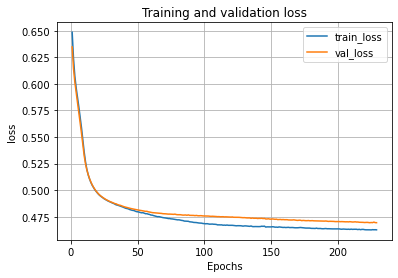

NN
0.7652120467117394
0.7563913470993117
---------------


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

early_stopping = EarlyStopping(patience=5)

clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0
    )

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')
clf_nn.save_weights('./blackboxes/adult_tf_nn')

from sklearn.metrics import accuracy_score
clf_nn.load_weights('./blackboxes/adult_tf_nn')
clf_nn.trainable = False

def predict(x, return_proba=False):
    if return_proba:
        return clf_nn.predict(x).ravel()
    else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()

print('NN')
print(accuracy_score(np.round(predict(X_train, return_proba = True)),y_train))
print(accuracy_score(np.round(predict(X_test, return_proba = True)),y_test))
print('---------------')

In [9]:
black_box = 'xgb'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

# Latent Space

In [10]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [53]:
latent_dim = 5
alpha = 1.5
batch_size = 1024
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3
idx_cat = [2,3,4,5,6]

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = torch.cdist(Z,Z)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, alpha, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = torch.cdist(X_cont,X_cont)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + alpha * D_class
    else:
        D = torch.cdist(X,X) + alpha * D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, alpha, idx_cat)
    Sz = compute_similarity_Z(Z, 1)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [54]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_adult.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_adult.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [55]:
model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

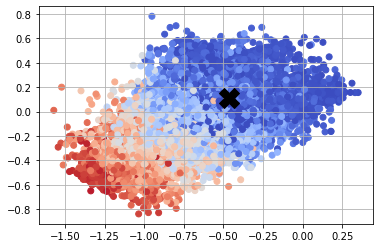

In [56]:
idx = 0
plt.scatter(Z_train[:,0],Z_train[:,1],c=y_train_pred,cmap='coolwarm')
plt.plot(Z_test[idx,0],Z_test[idx,1],'kX',markersize=20)
plt.grid()

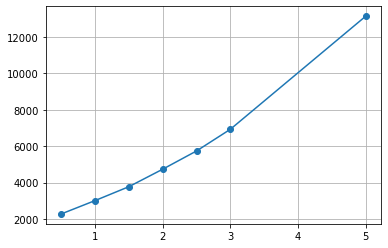

In [57]:
from sklearn.cluster import KMeans

sse = []

for alpha in [0.5,1,1.5,2,2.5,3,5]:
    model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

    kmeans = KMeans(n_clusters=2, random_state=rnd).fit(Z_train)
    sse.append(kmeans.inertia_)

plt.plot([0.5,1,1.5,2,2.5,3,5],sse,'-o')
plt.grid()

In [59]:
import numpy as np
from sklearn import datasets, svm
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist, pdist
from numpy.random import default_rng
from collections import Counter

def knn_clf(nbr_vec, y):
    '''
    Helper function to generate knn classification result.
    '''
    y_vec = y[nbr_vec]
    c = Counter(y_vec)
    return c.most_common(1)[0][0]

def knn_eval_series(X, y, n_neighbors_list=[1, 2, 3, 4, 5, 10, 15, 20], n_jobs=-1):
    '''
    This is a function that is used to evaluate the lower dimension embedding.
    An accuracy is calculated by an k-nearest neighbor classifier.
    A series of accuracy will be calculated for the given n_neighbors.
    Input:
        X: A numpy array with the shape [N, k]. The lower dimension embedding
           of some dataset. Expected to have some clusters.
        y: A numpy array with the shape [N, 1]. The labels of the original
           dataset.
        n_neighbors_list: A list of int.
        kwargs: Any keyword argument that is send into the knn clf.
    Output:
        accs: The avg accuracy generated by the clf, using leave one out cross val.
    '''
    avg_accs = []
    max_acc = X.shape[0]
    # Train once, reuse multiple times
    nbrs = NearestNeighbors(n_neighbors=n_neighbors_list[-1]+1, n_jobs=n_jobs).fit(X)
    distances, indices = nbrs.kneighbors(X)
    indices = indices [:, 1:]
    distances = distances[:, 1:]
    for n_neighbors in n_neighbors_list:
        sum_acc = 0
        for i in range(X.shape[0]):
            indices_temp = indices[:, :n_neighbors]
            result = knn_clf(indices_temp[i], y)
            if result == y[i]:
                sum_acc += 1
        avg_acc = sum_acc / max_acc
        avg_accs.append(avg_acc)
    return 1-np.array(avg_accs)

def random_triplet_eval(X, X_new, y):
    '''
    This is a function that is used to evaluate the lower dimension embedding.
    An triplet satisfaction score is calculated by evaluating how many randomly
    selected triplets have been violated. Each point will generate 5 triplets.
    Input:
        X: A numpy array with the shape [N, p]. The higher dimension embedding
           of some dataset. Expected to have some clusters.
        X_new: A numpy array with the shape [N, k]. The lower dimension embedding
               of some dataset. Expected to have some clusters as well.
        y: A numpy array with the shape [N, 1]. The labels of the original
           dataset. Used to identify clusters
    Output:
        acc: The score generated by the algorithm.
    '''    

    # Sampling Triplets
    # Five triplet per point
    anchors = np.arange(X.shape[0])
    rng = default_rng()
    triplets = rng.choice(anchors, (X.shape[0], 5, 2))
    triplet_labels = np.zeros((X.shape[0], 5))
    anchors = anchors.reshape((-1, 1, 1))
    
    # Calculate the distances and generate labels
    b = np.broadcast(anchors, triplets)
    distances = np.empty(b.shape)
    distances.flat = [np.linalg.norm(X[u] - X[v]) for (u,v) in b]
    labels = distances[:, :, 0] < distances[: , :, 1]

    # Calculate distances for LD
    b = np.broadcast(anchors, triplets)
    distances_l = np.empty(b.shape)
    distances_l.flat = [np.linalg.norm(X_new[u] - X_new[v]) for (u,v) in b]
    pred_vals = distances_l[:, :, 0] < distances_l[:, :, 1]
    correct = np.sum(pred_vals == labels)
    acc = correct/X.shape[0]/5
    return acc

def lof_eval(X, Z, n_jobs=-1):
    clf = LocalOutlierFactor(n_jobs=n_jobs)
    clf.fit(X)
    outlier_factor_input_space = clf.negative_outlier_factor_
    clf = LocalOutlierFactor(n_jobs=n_jobs)
    clf.fit(Z)
    outlier_factor_latent_space = clf.negative_outlier_factor_
    lof_score = np.mean((outlier_factor_input_space-outlier_factor_latent_space)**2)
    return lof_score
 
def isf_eval(X, Z, n_jobs=-1):
    clf = IsolationForest(n_jobs=n_jobs)
    clf.fit(X)
    outlier_factor_input_space = clf.score_samples(X)
    clf = IsolationForest(n_jobs=n_jobs)
    clf.fit(Z)
    outlier_factor_latent_space = clf.score_samples(Z)
    isf_score = np.mean((outlier_factor_input_space-outlier_factor_latent_space)**2)
    return isf_score


def compute_metrics(X, Z, Y, n_jobs=-1):    
    knn_score = np.mean(knn_eval_series(Z, Y, n_jobs=n_jobs))
    triplet_score = random_triplet_eval(X, Z, Y)
    lof_score = lof_eval(X, Z, n_jobs=n_jobs)
    isf_score = isf_eval(X, Z, n_jobs=n_jobs)
    return {'KNN':knn_score,
            'Triplet':triplet_score,
            'LOF':lof_score,
            'IsF':isf_score}


In [60]:
metrics = []

for alpha in [0.5,1,1.5,2,2.5,3,5]:
    model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()
    
    metrics.append(compute_metrics(X_train,Z_train,y_train.values))

Text(0.5, 1.0, 'IsF')

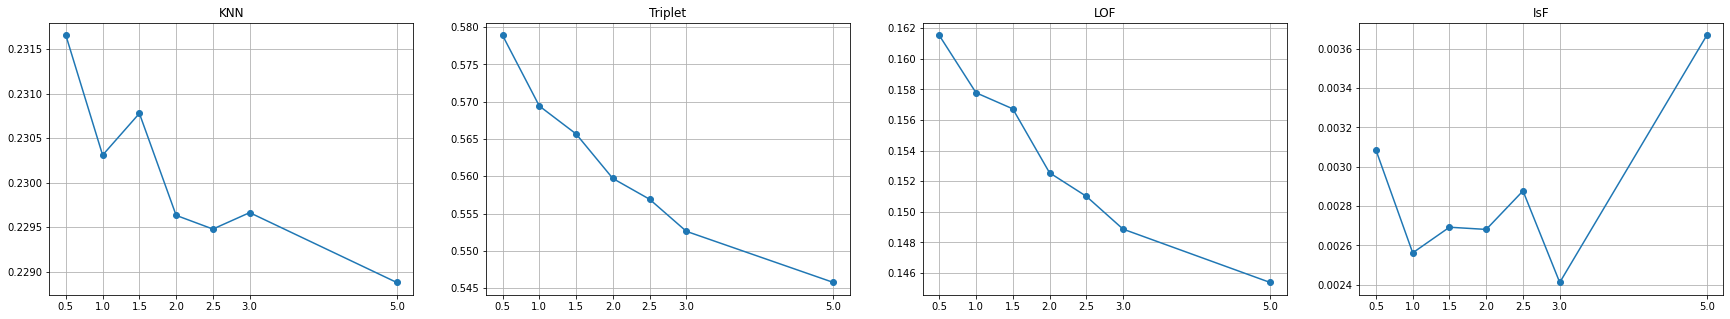

In [65]:
fig, ax = plt.subplots(1,4,figsize=(30,5))
ax[0].plot([0.5,1,1.5,2,2.5,3,5],[r['KNN'] for r in metrics], '-o')
ax[0].grid()
ax[0].set_xticks([0.5,1,1.5,2,2.5,3,5])
ax[0].set_title('KNN')
ax[1].plot([0.5,1,1.5,2,2.5,3,5],[r['Triplet'] for r in metrics], '-o')
ax[1].grid()
ax[1].set_xticks([0.5,1,1.5,2,2.5,3,5])
ax[1].set_title('Triplet')
ax[2].plot([0.5,1,1.5,2,2.5,3,5],[r['LOF'] for r in metrics], '-o')
ax[2].grid()
ax[2].set_xticks([0.5,1,1.5,2,2.5,3,5])
ax[2].set_title('LOF')
ax[3].plot([0.5,1,1.5,2,2.5,3,5],[r['IsF'] for r in metrics], '-o')
ax[3].grid()
ax[3].set_xticks([0.5,1,1.5,2,2.5,3,5]);
ax[3].set_title('IsF')

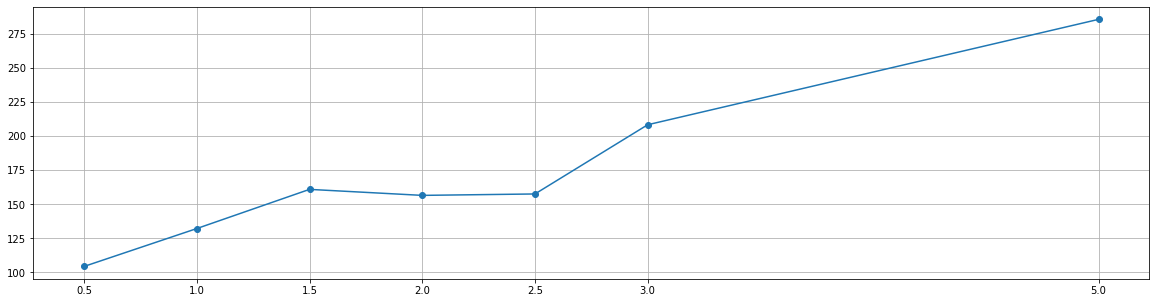

In [66]:
from numpy.linalg import norm

latent_dim = 5
spars = []

for alpha in [0.5,1,1.5,2,2.5,3,5]:
    model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

    y_contrib = model.fc1.weight.detach().numpy()[:,-1]
    thetas = np.arccos(np.round(np.dot(Z_train/norm(Z_train,axis=1).reshape(-1,1),y_contrib/norm(y_contrib)),5))
    spars.append(np.quantile(np.linalg.norm(Z_train)*np.sin(thetas),0.75))

plt.figure(figsize=(20,5))
plt.plot([0.5,1,1.5,2,2.5,3,5],spars,'-o')
plt.xticks([0.5,1,1.5,2,2.5,3,5])
plt.grid()

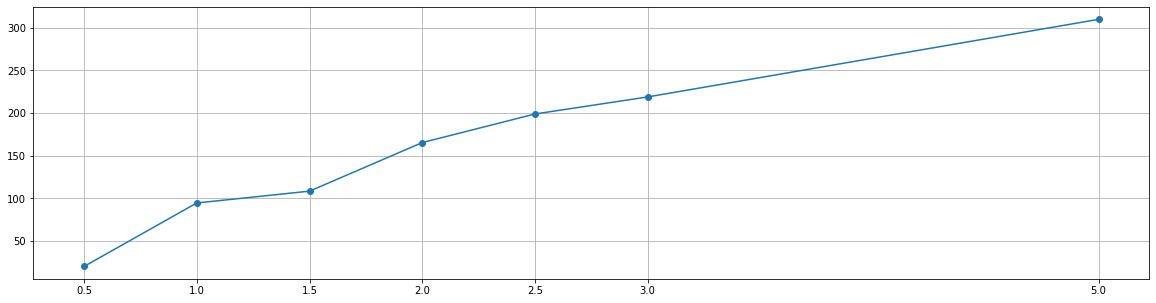

In [67]:
from numpy.linalg import norm

latent_dim = 5
spars = []

for alpha in [0.5,1,1.5,2,2.5,3,5]:
    model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

    y_contrib = model.fc1.weight.detach().numpy()[:,-1]
    thetas = np.arccos(np.round(np.dot(Z_train/norm(Z_train,axis=1).reshape(-1,1),y_contrib/norm(y_contrib)),5))
    spars.append(np.quantile(np.linalg.norm(Z_train)*np.cos(thetas),0.75))

plt.figure(figsize=(20,5))
plt.plot([0.5,1,1.5,2,2.5,3,5],spars,'-o')
plt.xticks([0.5,1,1.5,2,2.5,3,5])
plt.grid()

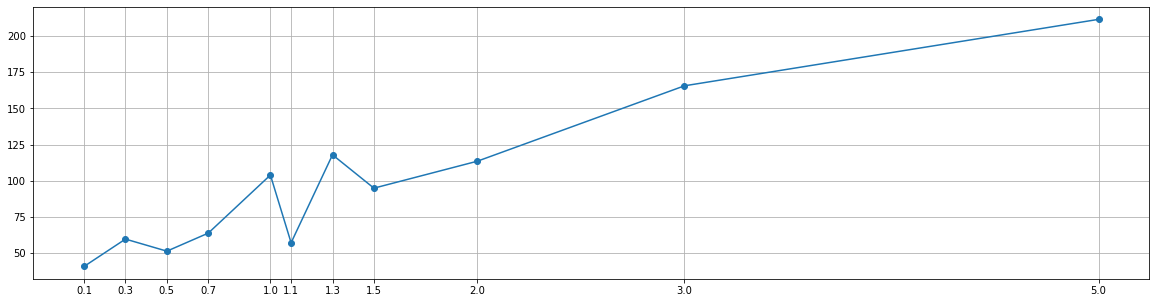

In [ ]:
from numpy.linalg import norm

spars = []

for alpha in [0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5]:
    model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

    y_contrib = model.fc1.weight.detach().numpy()[:,-1]
    thetas = np.arccos(np.round(np.dot(Z_train/norm(Z_train,axis=1).reshape(-1,1),y_contrib/norm(y_contrib)),5))
    spars.append(np.quantile(np.linalg.norm(Z_train)*np.sin(thetas),0.8))

plt.figure(figsize=(20,5))
plt.plot([0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5],spars,'-o')
plt.xticks([0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5])
plt.grid()

In [209]:
idx = 0
predict(X_test[idx:idx+1,:-1],return_proba=True)

array([0.01908733], dtype=float32)

In [210]:
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

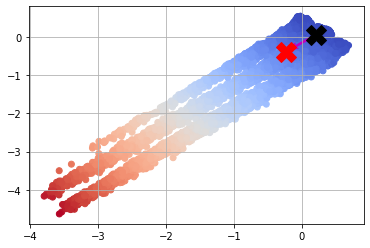

In [211]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.plot(Z_test[idx,0], Z_test[idx,1], 'kX', markersize=20)
m = +0.1
plt.plot(Z_test[idx,0]+m*y_contrib[0], Z_test[idx,1]+m*y_contrib[1], 'rX', markersize=20)
plt.quiver(Z_test[idx,0], Z_test[idx,1], m*y_contrib[0],m*y_contrib[1], angles='xy', scale_units='xy', scale=1, color='m')
plt.grid()

### Other Explanation

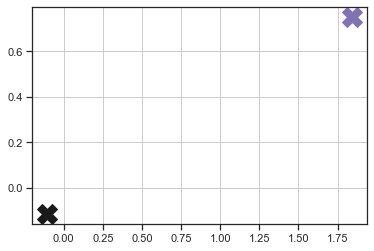

In [498]:
import math

idx = 0
m = +2
p_in = Z_test[idx,:]
p_fin = Z_test[idx,:]+m*y_contrib

eps = 0.01
delta = math.sqrt((eps**2)/2)

rule_1 = (Z_train[:,0]-(p_in[0]+delta))/(p_fin[0]-p_in[0])>(Z_train[:,1]-(p_in[1]+delta))/(p_fin[1]-p_in[1])
rule_2 = (Z_train[:,0]-(p_in[0]-delta))/(p_fin[0]-p_in[0])<(Z_train[:,1]-(p_in[1]-delta))/(p_fin[1]-p_in[1])
rule_3 = Z_train[:,1]>Z_train[:,0]-p_in[0]+p_in[1]
rule_4 = Z_train[:,1]<Z_train[:,0]-p_fin[0]+p_fin[1]
rule = rule_1*rule_2*rule_3*rule_4
neigh_eps_train = X_train[rule,:]

plt.scatter(Z_train[rule,0], Z_train[rule,1], c=y_train_pred[rule], cmap='coolwarm')
plt.plot(p_in[0], p_in[1], 'kX', markersize=20)
plt.plot(p_fin[0], p_fin[1], 'mX', markersize=20)
plt.grid()

rule_1 = (Z_test[:,0]-(p_in[0]+delta))/(p_fin[0]-p_in[0])>(Z_test[:,1]-(p_in[1]+delta))/(p_fin[1]-p_in[1])
rule_2 = (Z_test[:,0]-(p_in[0]-delta))/(p_fin[0]-p_in[0])<(Z_test[:,1]-(p_in[1]-delta))/(p_fin[1]-p_in[1])
rule_3 = Z_test[:,1]>Z_test[:,0]-p_in[0]+p_in[1]
rule_4 = Z_test[:,1]<Z_test[:,0]-p_fin[0]+p_fin[1]
rule = rule_1*rule_2*rule_3*rule_4
neigh_eps_test = X_test[rule,:]


train acc: 0.9312169312169312
test acc: 0.8295454545454546


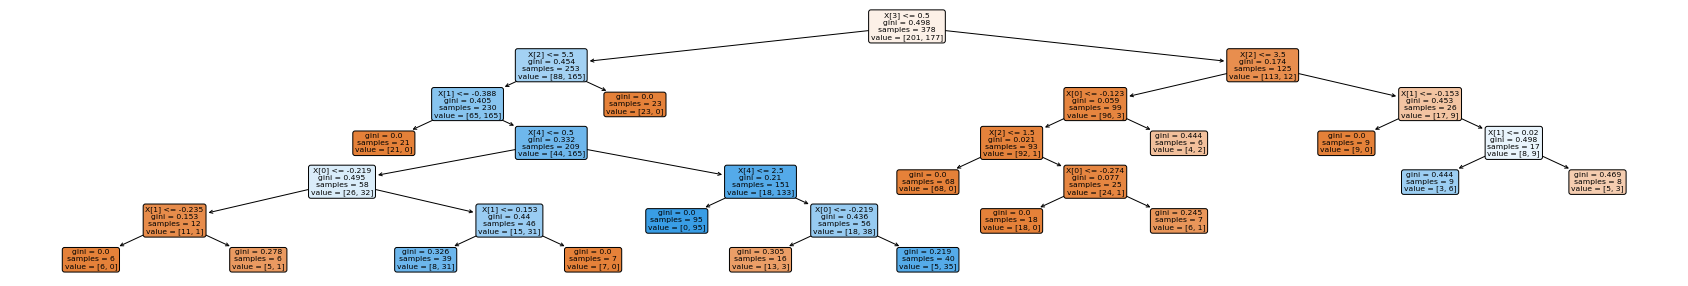

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=6,min_samples_leaf=5)
clf.fit(neigh_eps_train[:,:-1],np.round(neigh_eps_train[:,-1]))
plt.figure(figsize=(30,5))
print('train acc:', clf.score(neigh_eps_train[:,:-1], np.round(neigh_eps_train[:,-1])))
print('test acc:', clf.score(neigh_eps_test[:,:-1], np.round(neigh_eps_test[:,-1])))
tree.plot_tree(clf,filled=True,rounded=True);

In [33]:
pd.DataFrame([q], columns = df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,-0.534247,-0.653061,0.0,1.0,0.0,1.0,1.0,0.035054


In [58]:
p = neigh_eps_train[(neigh_eps_train[:,3]==1)*(neigh_eps_train[:,2]<=3.5)*(neigh_eps_train[:,0]>=-0.123)*(neigh_eps_train[:,2]<=0.5)]
pd.DataFrame(p, columns = df.columns)

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
0,-0.095890,0.204082,0.0,1.0,2.0,1.0,1.0,0.528033
1,-0.068493,0.204082,0.0,1.0,1.0,1.0,1.0,0.542199


In [63]:
q = X_test[idx,:].copy()
print('original:', predict(q[:-1],return_proba=True))
q_mod = q.copy()
#q_mod[0] = 0
q_mod[1] = -0.388
#q_mod[2] = 0
q_mod[3] = 0
q_mod[4] = 1
#q_mod[5] = 0
#q_mod[6] = 0
print('mod:', predict(q_mod[:-1],return_proba=True))

original: [0.03505402]
mod: [0.53541255]


### Counterfactual Explanation

In [167]:
q = X_test[0].copy()
predict(q[:-1].reshape(1,-1),return_proba=True)

array([0.01908733], dtype=float32)

In [168]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
w

array([[-1.7977472e-01,  8.0004409e-03,  1.0495271e-02, -3.8187104e-01,
        -1.2387718e-02,  1.4856439e-02, -3.0209449e-01, -2.6730378e+00],
       [ 2.3481296e-01,  4.5024389e-01,  2.2590892e-04, -6.1456785e-02,
        -2.6892573e-02, -2.1644342e-03, -1.9712257e-01,  3.1278222e+00],
       [ 2.3043343e-01, -3.0987623e-01,  6.1476869e-03, -3.1345299e-01,
         2.9326745e-03,  1.5136696e-01,  8.3734117e-02,  2.6015294e+00],
       [ 1.8708806e-01,  2.0367980e-01,  2.5907629e-03,  1.6965523e-02,
        -1.0749835e-02,  4.1256982e-01,  1.0495081e-01, -2.5009484e+00],
       [-4.3359989e-01,  8.0518104e-02, -7.4295201e-03, -3.8879212e-02,
         4.7346409e-03,  2.4347022e-01,  4.2890392e-02,  2.8531926e+00]],
      dtype=float32)

In [169]:
def compute_cf(q, indexes):
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        #print(delta_i)
        q_cf[indexes] += delta_i
        q_cf[2] = np.round(np.clip(q_cf[2],0,6))
        q_cf[3] = np.round(np.clip(q_cf[3],0,1))
        q_cf[4] = np.round(np.clip(q_cf[4],0,4))
        q_cf[5] = np.round(np.clip(q_cf[5],0,1))
        q_cf[6] = np.round(np.clip(q_cf[6],0,1))
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
    return q_cf

In [170]:
idx = 0
q = X_test[idx,:].copy()
print(predict(q[:-1].reshape(1,-1),return_proba=True))


[0.01908733]


In [171]:
from itertools import combinations

q = X_test[idx,:].copy()
q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
print(q_pred)
q_cfs = []
l_i = []
l_f = []

for indexes in  list(combinations(list(range(7)),2)):    
    q_cf = compute_cf(q, list(indexes))
    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
    if q_pred:
        if q_cf_pred<0.5:
            q_cfs.append(q_cf)
    else:
        if q_cf_pred>0.5:
            q_cfs.append(q_cf) 
    l_i.append([list(indexes),q_cf_pred])
r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
l_i = np.array(l_i,dtype=object)[r,0]

while len(l_i[0])<6:
    for e in l_i:
        for i in list(np.delete(range(7),e)):
            q_cf = compute_cf(q, e+[i])
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 
            l_f.append([e+[i],q_cf_pred])
    r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
    l_f = np.array(l_f,dtype=object)[r,0]
    l_i = l_f.copy()
    l_f = []

q_cfs = np.vstack(q_cfs)

[0]


In [172]:
q_cfs.shape

(39, 8)

In [173]:
from scipy.spatial.distance import cdist, euclidean

print(np.min(cdist(q_cfs[:,[2,3,4,5,6]],q[[2,3,4,5,6]].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,[0,1]],q[[0,1]].reshape(1,-1),metric='euclidean')))
print(np.min(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean'))
)

0.4
0.02028983795768302


In [174]:
from itertools import combinations
from tqdm.notebook import tqdm

d_dist = []
d_impl = []

for idx in tqdm(range(10)):
    q = X_test[idx,:].copy()
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
    q_cfs = []
    l_i = []
    l_f = []

    for indexes in  list(combinations(list(range(7)),2)):    
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 
        l_i.append([list(indexes),q_cf_pred])
    r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
    l_i = np.array(l_i,dtype=object)[r,0]

    while len(l_i[0])<6:
        for e in l_i:
            for i in list(np.delete(range(7),e)):
                q_cf = compute_cf(q, e+[i])
                q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                if q_pred:
                    if q_cf_pred<0.5:
                        q_cfs.append(q_cf)
                else:
                    if q_cf_pred>0.5:
                        q_cfs.append(q_cf) 
                l_f.append([e+[i],q_cf_pred])
        r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
        l_f = np.array(l_f,dtype=object)[r,0]
        l_i = l_f.copy()
        l_f = []
    
    if len(q_cfs)<1:
        continue
    else:
        q_cfs = np.vstack(q_cfs)
        d_dist.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],q[[2,3,4,5,6]].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,[0,1]],q[[0,1]].reshape(1,-1),metric='euclidean')))
        d_impl.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean')))

  0%|          | 0/10 [00:00<?, ?it/s]

In [175]:
print(np.mean(np.array(d_dist)))
print(np.mean(np.array(d_impl)))

0.3893377454020084
0.00911249090585905


In [176]:
len(d_dist)

10

In [220]:
d_dists = []
d_impls = []

for alpha in [0.5,1,1.5,2,2.5,3,5]:
    model.load_state_dict(torch.load(f'./models/adult_latent_{black_box}_{latent_dim}_{str(alpha).replace(".", "")}.pt'))
    with torch.no_grad():
        model.eval()
        Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
        Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()
    
    w = model.fc1.weight.detach().numpy()
    b = model.fc1.bias.detach().numpy()
    y_contrib = model.fc1.weight.detach().numpy()[:,-1]

    from itertools import combinations
    from tqdm.notebook import tqdm

    d_dist = []
    d_impl = []

    for idx in tqdm(range(10)):
        q = X_test[idx,:].copy()
        q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
        q_cfs = []
        l_i = []
        l_f = []

        for indexes in  list(combinations(list(range(7)),2)):    
            q_cf = compute_cf(q, list(indexes))
            q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 
            l_i.append([list(indexes),q_cf_pred])
        r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
        l_i = np.array(l_i,dtype=object)[r,0]

        while len(l_i[0])<6:
            for e in l_i:
                for i in list(np.delete(range(7),e)):
                    q_cf = compute_cf(q, e+[i])
                    q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                    if q_pred:
                        if q_cf_pred<0.5:
                            q_cfs.append(q_cf)
                    else:
                        if q_cf_pred>0.5:
                            q_cfs.append(q_cf) 
                    l_f.append([e+[i],q_cf_pred])
            r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
            l_f = np.array(l_f,dtype=object)[r,0]
            l_i = l_f.copy()
            l_f = []
        
        if len(q_cfs)<1:
            continue
        else:
            q_cfs = np.vstack(q_cfs)
            d_dist.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],q[[2,3,4,5,6]].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,[0,1]],q[[0,1]].reshape(1,-1),metric='euclidean')))
            d_impl.append(np.min(cdist(q_cfs[:,[2,3,4,5,6]],X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cfs[:,[0,1]],X_train[:,[0,1]],metric='euclidean')))
    d_dists.append(np.mean(np.array(d_dist)))
    d_impls.append(np.mean(np.array(d_impl)))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

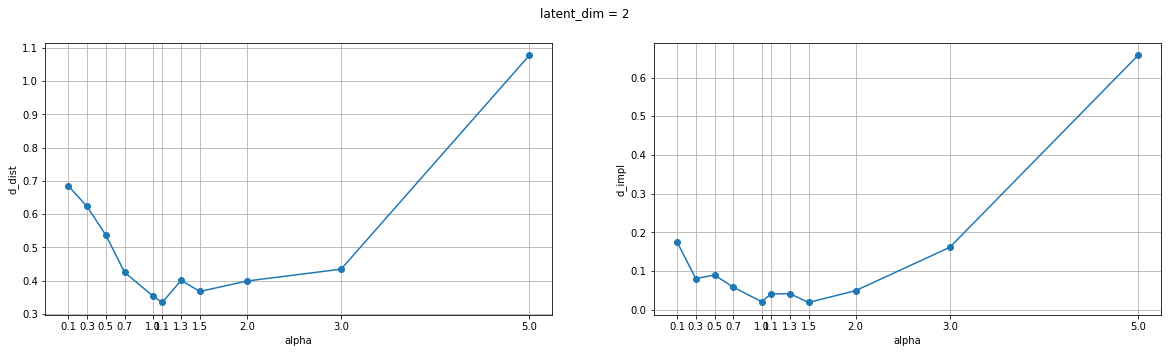

In [219]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle('latent_dim = 2')
ax[0].plot([0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5],d_dists,'-o')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('d_dist')
ax[0].set_xticks([0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5])
ax[0].grid(True)
ax[1].plot([0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5],d_impls,'-o')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('d_impl')
ax[1].grid(True)
ax[1].set_xticks([0.1,0.3,0.5,0.7,1,1.1,1.3,1.5,2,3,5]);

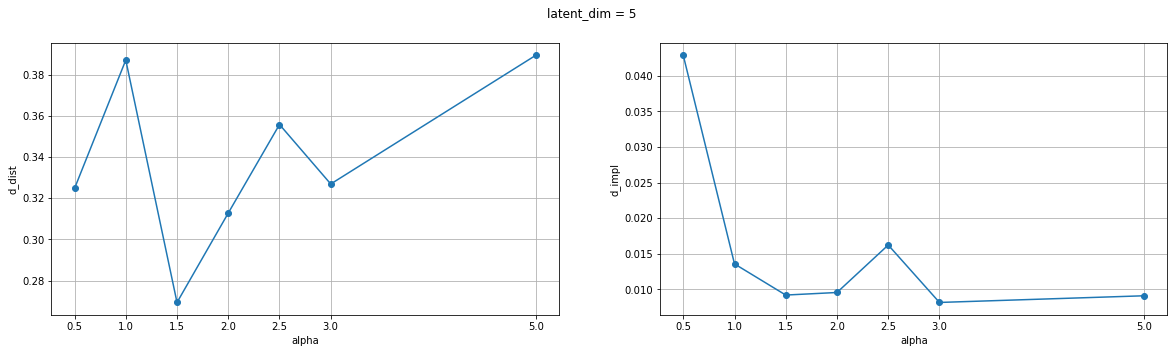

In [221]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
fig.suptitle('latent_dim = 5')
ax[0].plot([0.5,1,1.5,2,2.5,3,5],d_dists,'-o')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('d_dist')
ax[0].set_xticks([0.5,1,1.5,2,2.5,3,5])
ax[0].grid(True)
ax[1].plot([0.5,1,1.5,2,2.5,3,5],d_impls,'-o')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('d_impl')
ax[1].grid(True)
ax[1].set_xticks([0.5,1,1.5,2,2.5,3,5]);

# Growing Spheres

In [47]:
from growingspheres import counterfactuals as cf

idx = 0
q = X_test[idx,:-1].reshape(1,-1).copy()
pred = int(predict(q))
print(pred)

CF = cf.CounterfactualExplanation(q, predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=True)
q_cf_GS = CF.enemy
print(predict(q_cf_GS.reshape(1,-1)))

0
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  42
Final radius:  (0.7480000000000003, 0.7660000000000003)
Final number of ennemies:  1
Feature selection...
Reduced 5 coordinates
[1]


In [48]:
pd.DataFrame(np.vstack([q,q_cf_GS.reshape(1,-1)]), columns = df.columns[:-1])

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country
0,-0.534247,-0.653061,0.0,1.000000,0.0,1.0,1.0
1,-0.534247,-0.119183,0.0,0.477352,0.0,1.0,1.0


In [49]:
from scipy.spatial.distance import cdist, euclidean

print(float(cdist(q_cf_GS[[2,3,4,5,6]].reshape(1,-1),q[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cf_GS[[0,1]].reshape(1,-1),q[:,[0,1]],metric='euclidean')))
print(np.min(cdist(q_cf_GS[[2,3,4,5,6]].reshape(1,-1),X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cf_GS[[0,1]].reshape(1,-1),X_train[:,[0,1]],metric='euclidean')))

0.733877731605663
0.23231843483336345


In [50]:
d_dist_GS = []
d_impl_GS = []

for idx in tqdm(range(100)):
    q = X_test[idx,:-1].reshape(1,-1).copy()
    CF = cf.CounterfactualExplanation(q, predict, method='GS')
    CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=False)
    q_cf_GS = CF.enemy
    d_dist_GS.append(float(cdist(q_cf_GS[[2,3,4,5,6]].reshape(1,-1),q[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cf_GS[[0,1]].reshape(1,-1),q[:,[0,1]],metric='euclidean')))
    d_impl_GS.append(np.min(cdist(q_cf_GS[[2,3,4,5,6]].reshape(1,-1),X_train[:,[2,3,4,5,6]],metric='hamming') + cdist(q_cf_GS[[0,1]].reshape(1,-1),X_train[:,[0,1]],metric='euclidean')))

  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
print(np.mean(np.array(d_dist_GS)))
print(np.mean(np.array(d_impl_GS)))

0.3003364908782644
0.1709238847241318


In [52]:
len(d_dist_GS)

100

# DICE

In [10]:
import dice_ml

dataset = pd.concat((X_train,y_train),axis=1)
d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hoursPerWeek'], outcome_name='income')

In [11]:
m = dice_ml.Model(model=clf_rf, backend='sklearn')

In [12]:
# initiate DiCE
exp_random = dice_ml.Dice(d, m, method='random')

In [13]:
dataset

,age,hoursPerWeek,marital_status,gender,native_country,Bachelors,CommunityCollege,Doctorate,HighGrad,Masters,ProfSchool,dropout,BlueCollar,ExecManagerial,ProfSpecialty,Sales,Services,income
46220,0.342466,0.000000,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0
15910,-0.534247,0.612245,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2746,-0.726027,-0.367347,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
40636,-0.424658,0.204082,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
6931,-0.041096,0.693878,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39461,-0.561644,-0.102041,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0
16951,-0.150685,-0.204082,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0
28487,-0.123288,0.000000,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
11005,-0.671233,-0.204082,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0


In [14]:
query_instances = dataset.iloc[0:1,:-1]

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, 
                                                      total_CFs=1, 
                                                      desired_class="opposite", 
                                                      verbose=True,
                                                      permitted_range={'age':[-1, 1], 'hoursPerWeek':[-1, 1]})

#dice_exp_random.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec
